In [354]:
!pip install Sastrawi

In [355]:
!pip install pandarallel

In [356]:
!pip install nltk

In [357]:
# ==== General Utilities ====
import os
import re
import string
import pickle
import numpy as np
import pandas as pd
from PIL import Image

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# ==== Parallel Processing ====
from pandarallel import pandarallel

# ==== Text Processing ====
import nltk # Import the nltk module explicitly
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PorterStemmer
from bs4 import BeautifulSoup
from string import punctuation

# ==== Bahasa Indonesia NLP ====
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# ==== TensorFlow / Keras ====
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, LSTM, Dropout, GRU, BatchNormalization
)
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [358]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [359]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [360]:
# from google.colab import files
# uploaded = files.upload()

In [361]:
# !unzip "/content/drive/MyDrive/dataset (1)/Data BDC - Satria Data 2020.zip" -d "hoax_dataset"

In [362]:
train_data = pd.read_excel("/content/drive/MyDrive/dataset (1)/Hoax_dataset/training/Data Latih BDC.xlsx",engine="openpyxl")
test_data = pd.read_excel("/content/drive/MyDrive/dataset (1)/Hoax_dataset/testing/Data Uji BDC.xlsx",engine="openpyxl")

In [363]:
train_data.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [364]:
test_data.head()

,ID,tanggal,judul,narasi,nama file gambar
0,238057,2020-07-13 00:00:00,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,238057.jpg
1,238158,2020-07-06 00:00:00,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...,238158.jpg
2,238865,2020-04-22 00:00:00,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...,238865.jpg
3,248298,2019-10-22 00:00:00,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,248298.jpg
4,255176,2020-05-01 00:00:00,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran...",255176.jpg


In [365]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   tanggal           4231 non-null   object
 3   judul             4231 non-null   object
 4   narasi            4231 non-null   object
 5   nama file gambar  4231 non-null   object
dtypes: int64(2), object(4)
memory usage: 198.5+ KB


# Preprocessing

In [366]:
stop_words = set(stopwords.words('indonesian'))

In [367]:
# Fungsi cleaning teks
def clean_text(text):
    text = str(text).lower()                                      # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)           # hapus URL
    text = re.sub(r'<.*?>', '', text)                             # hapus HTML
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)                    # hapus mention
    text = re.sub(r'#\w+', '', text)                              # hapus hashtag
    text = re.sub(r'[^a-z\s]', '', text)                          # hanya huruf dan spasi
    text = re.sub(r'\b\w\b', '', text)                            # hapus kata 1 huruf
    text = re.sub(r'\s+', ' ', text).strip()                      # normalisasi spasi
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [368]:
def preprocess_dataframe(df, is_train=True):
    # Gabungkan judul + narasi
    df['teks'] = (df['judul'].fillna('') + ' ' + df['narasi'].fillna('')).apply(clean_text)

    # Hapus duplikat berdasarkan teks bersih
    df = df.drop_duplicates(subset='teks').reset_index(drop=True)

    # Jika data latih, pastikan kolom label tetap ada
    if is_train and 'label' not in df.columns:
        raise ValueError("Data latih harus mengandung kolom 'label'.")

    return df

In [369]:
train_data = preprocess_dataframe(train_data, is_train=True)
test_data = preprocess_dataframe(test_data, is_train=False)

# EDA

<ipython-input-370-95e22087bf52>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


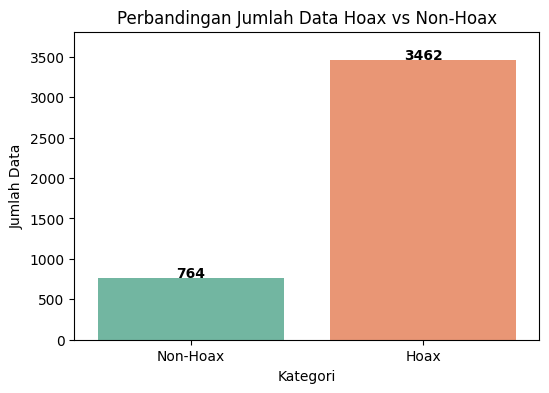

In [370]:
# Buat DataFrame ringkasan
label_counts = train_data['label'].value_counts().sort_index()
label_counts.index = ['Non-Hoax', 'Hoax']

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')

plt.title("Perbandingan Jumlah Data Hoax vs Non-Hoax")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.ylim(0, max(label_counts.values)*1.1)
plt.show()

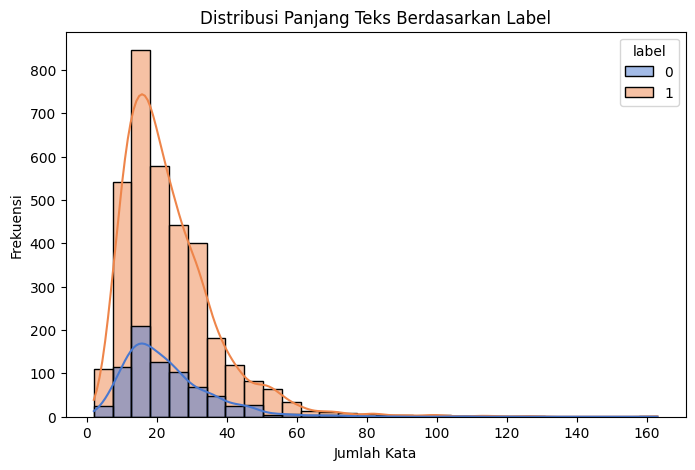

In [371]:
# 2. Panjang teks (dalam jumlah kata)
train_data['panjang_teks'] = train_data['teks'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(data=train_data, x='panjang_teks', bins=30, hue='label', kde=True, palette='muted')
plt.title("Distribusi Panjang Teks Berdasarkan Label")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

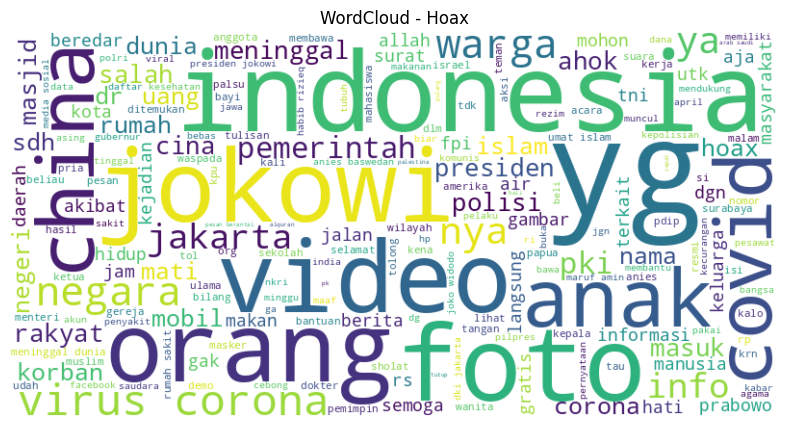

In [372]:
# 3. Wordcloud Hoax dan Non-Hoax
def generate_wordcloud(df_subset, label_name):
    text = " ".join(df_subset['teks'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label_name}")
    plt.show()

generate_wordcloud(train_data[train_data['label'] == 1], "Hoax")

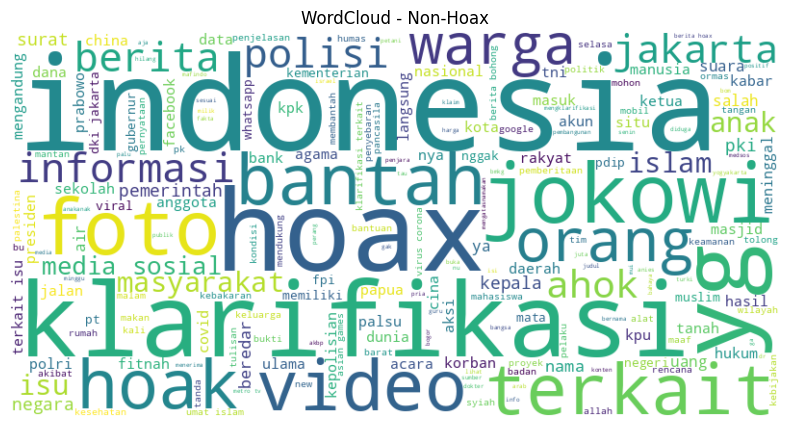

In [373]:
generate_wordcloud(train_data[train_data['label'] == 0], "Non-Hoax")

# Feature Extraction Using TF-IDF

In [374]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,          # Ambil 5000 kata paling penting
    ngram_range=(1, 2),         # Termasuk unigram dan bigram
    stop_words=None,            # Sudah dibersihkan sebelumnya
    sublinear_tf=True,          # Skala TF secara logaritmik
    norm='l2'                   # Normalisasi L2
)

# Transformasi teks menjadi vektor fitur
X = vectorizer.fit_transform(train_data['teks'])   # Data latih
X_test = vectorizer.transform(test_data['teks'])   # Data uji
y = train_data['label']                            # Target klasifikasi


# Modelling

In [375]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Terapkan SMOTE hanya pada data latih
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Sekarang latih model dengan data yang seimbang
model.fit(X_train_balanced, y_train_balanced)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_...
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=500,
                                                   random_state=42)),
                               ('svm',
                                SVC(class_weight='balanced', probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression(max_iter=500,
                                                      random_state=42),
                   n_jobs=-1)

In [376]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.31      0.43       153
           1       0.86      0.98      0.92       693

    accuracy                           0.85       846
   macro avg       0.80      0.64      0.67       846
weighted avg       0.84      0.85      0.83       846



In [377]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

# Definisikan base learners
base_learners = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=300)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lr', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)),
    ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
]

# Meta learner
meta_learner = LogisticRegression(max_iter=500, random_state=42)

# Buat model stacking
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False  # Jika True, fitur asli juga digunakan di meta-learner
)

# Latih model stacking
stacking_clf.fit(X_train, y_train)

# Prediksi pada validation set
y_pred_stack = stacking_clf.predict(X_val)

In [378]:
# 2. Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

In [379]:
# 3. Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

In [380]:
# 4. Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

In [381]:
# 5. Support Vector Machine
svm_model = LinearSVC(class_weight='balanced', max_iter=1000)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

In [382]:
# 6. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       153
           1       0.89      0.88      0.89       693

    accuracy                           0.82       846
   macro avg       0.69      0.70      0.70       846
weighted avg       0.82      0.82      0.82       846



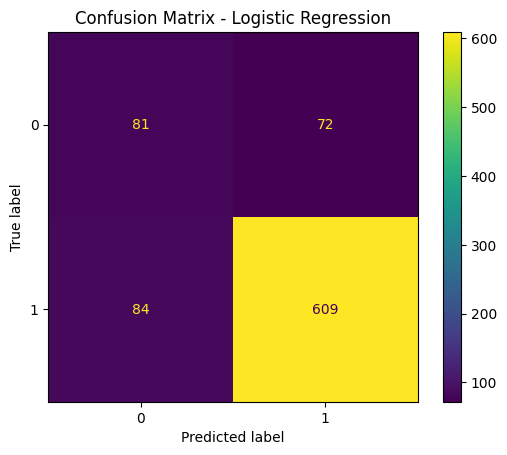

In [383]:
# 7. Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

evaluate_model(y_val, y_pred_lr, "Logistic Regression")


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.80      0.33      0.47       153
           1       0.87      0.98      0.92       693

    accuracy                           0.86       846
   macro avg       0.83      0.66      0.70       846
weighted avg       0.86      0.86      0.84       846



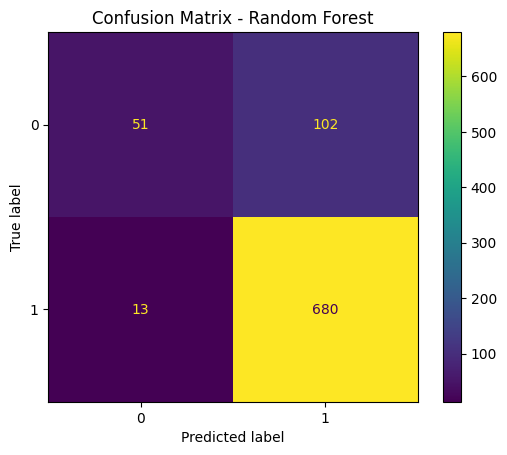

In [384]:
evaluate_model(y_val, y_pred_rf, "Random Forest")

=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.79      0.07      0.13       153
           1       0.83      1.00      0.90       693

    accuracy                           0.83       846
   macro avg       0.81      0.53      0.52       846
weighted avg       0.82      0.83      0.77       846



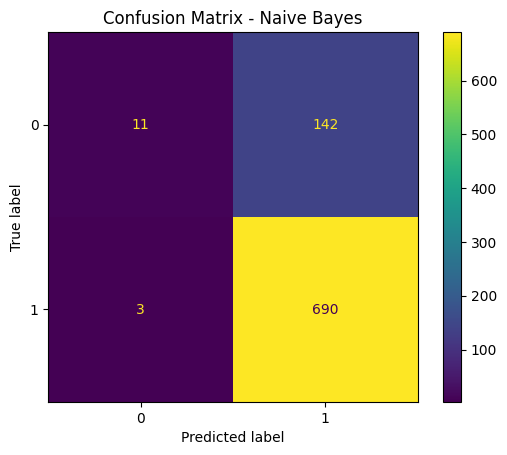

In [385]:
# Evaluasi Naive Bayes
evaluate_model(y_val, y_pred_nb, "Naive Bayes")

=== SVM ===
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       153
           1       0.87      0.87      0.87       693

    accuracy                           0.79       846
   macro avg       0.65      0.65      0.65       846
weighted avg       0.79      0.79      0.79       846



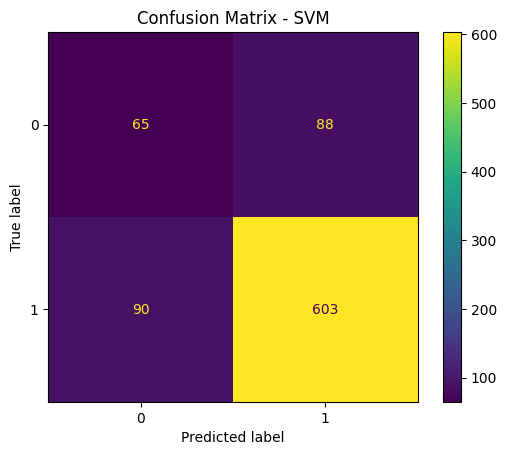

In [386]:
# Evaluasi SVM
evaluate_model(y_val, y_pred_svm, "SVM")

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.71      0.30      0.42       153
           1       0.86      0.97      0.91       693

    accuracy                           0.85       846
   macro avg       0.79      0.64      0.67       846
weighted avg       0.83      0.85      0.83       846



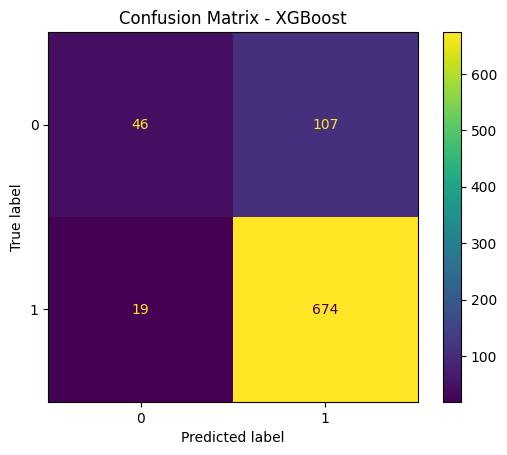

In [387]:
# Evaluasi XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
evaluate_model(y_val, y_pred_xgb, "XGBoost")

=== Stacking Ensemble ===
              precision    recall  f1-score   support

           0       0.75      0.35      0.47       153
           1       0.87      0.97      0.92       693

    accuracy                           0.86       846
   macro avg       0.81      0.66      0.70       846
weighted avg       0.85      0.86      0.84       846

F1-score Stacking Ensemble: 0.8389


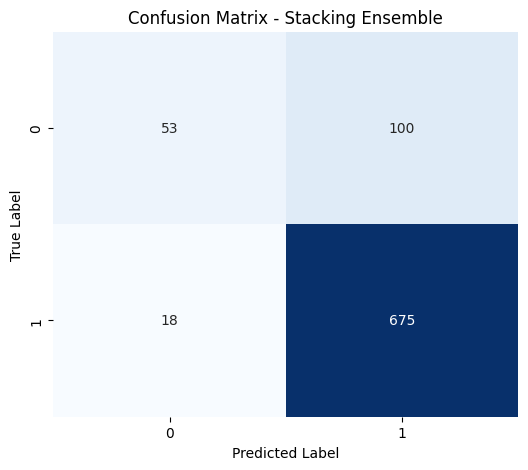

In [388]:
# Evaluasi
print("=== Stacking Ensemble ===")
print(classification_report(y_val, y_pred_stack))
f1_stack = f1_score(y_val, y_pred_stack, average='weighted')
print(f"F1-score Stacking Ensemble: {f1_stack:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_stack)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

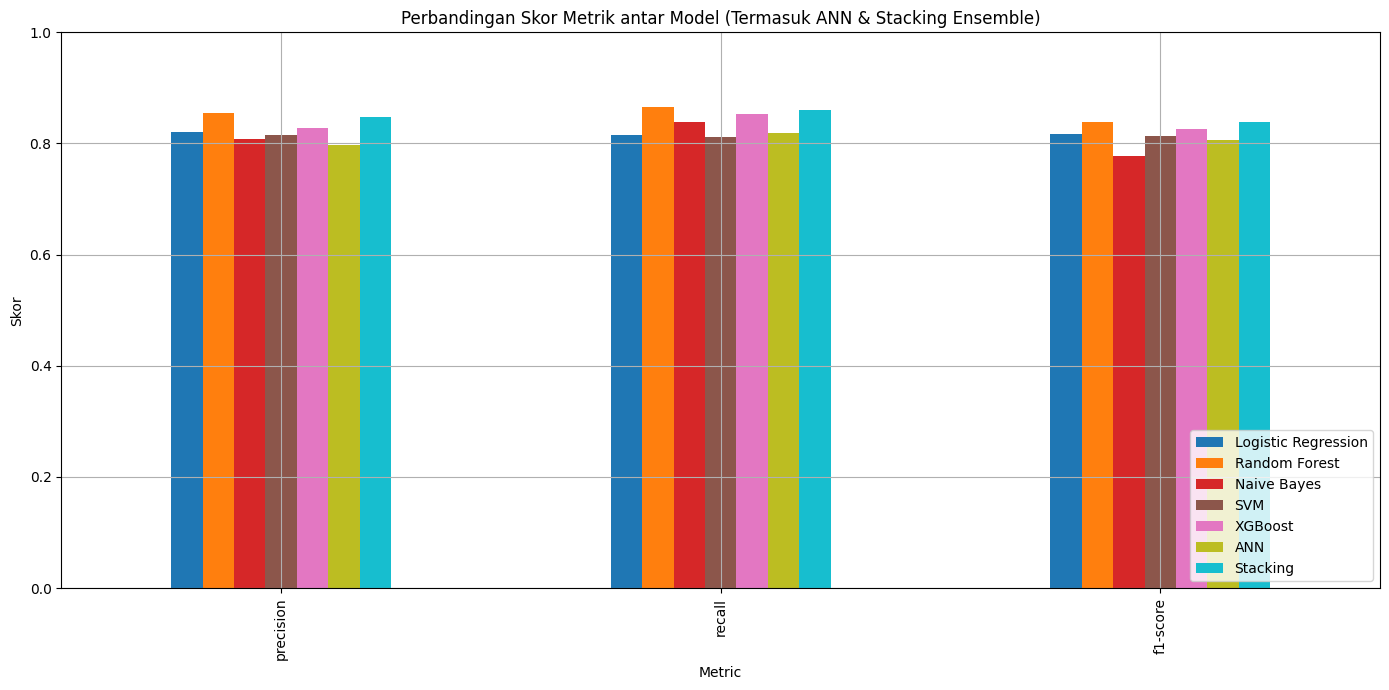

In [389]:
# Ambil classification report dari model Stacking
report_stack = classification_report(y_val, y_pred_stack, output_dict=True)

# Update DataFrame perbandingan dengan semua model termasuk Stacking
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': [report_lr['weighted avg'][m] for m in metrics],
    'Random Forest': [report_rf['weighted avg'][m] for m in metrics],
    'Naive Bayes': [report_nb['weighted avg'][m] for m in metrics],
    'SVM': [report_svm['weighted avg'][m] for m in metrics],
    'XGBoost': [report_xgb['weighted avg'][m] for m in metrics],
    'ANN': [report_ann['weighted avg'][m] for m in metrics],
    'Stacking': [report_stack['weighted avg'][m] for m in metrics]  # Tambahan Stacking
})

# Plot hasil perbandingan semua model
comparison_df.set_index('Metric').plot(kind='bar', figsize=(14, 7), colormap='tab10')
plt.ylim(0, 1)
plt.title("Perbandingan Skor Metrik antar Model (Termasuk ANN & Stacking Ensemble)")
plt.ylabel("Skor")
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [390]:
models = {
    'Logistic Regression': (lr_model, y_pred_lr),
    'Random Forest': (rf_model, y_pred_rf),
    'Naive Bayes': (nb_model, y_pred_nb),
    'SVM': (svm_model, y_pred_svm),
    'XGBoost': (xgb_model, y_pred_xgb),
    'Stacking': (stacking_clf, y_pred_stack)
}

# Cari model dengan f1-score tertinggi (weighted avg)
best_model_name = None
best_model = None
best_f1 = 0

for name, (model, y_pred) in models.items():
    report = classification_report(y_val, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    print(f"{name}: F1-score = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_model_name = name

print(f"\nModel terbaik yang dipilih: {best_model_name} (F1-score: {best_f1:.4f})")


Logistic Regression: F1-score = 0.8183
Random Forest: F1-score = 0.8403
Naive Bayes: F1-score = 0.7651
SVM: F1-score = 0.7901
XGBoost: F1-score = 0.8254
Stacking: F1-score = 0.8389

Model terbaik yang dipilih: Random Forest (F1-score: 0.8403)


=== Classification Report Sebelum Tuning ===
              precision    recall  f1-score   support

           0       0.69      0.36      0.47       153
           1       0.87      0.96      0.92       693

    accuracy                           0.85       846
   macro avg       0.78      0.66      0.69       846
weighted avg       0.84      0.85      0.84       846

Fitting 2 folds for each of 6 candidates, totalling 12 fits
=== Classification Report Setelah Tuning ===
              precision    recall  f1-score   support

           0       0.72      0.36      0.48       153
           1       0.87      0.97      0.92       693

    accuracy                           0.86       846
   macro avg       0.80      0.66      0.70       846
weighted avg       0.85      0.86      0.84       846


📊 Perbandingan Metrik:
      Metric  Sebelum Tuning  Setelah Tuning
0  precision        0.838684        0.845773
1     recall        0.854610        0.859338
2   f1-score        0.835471        0

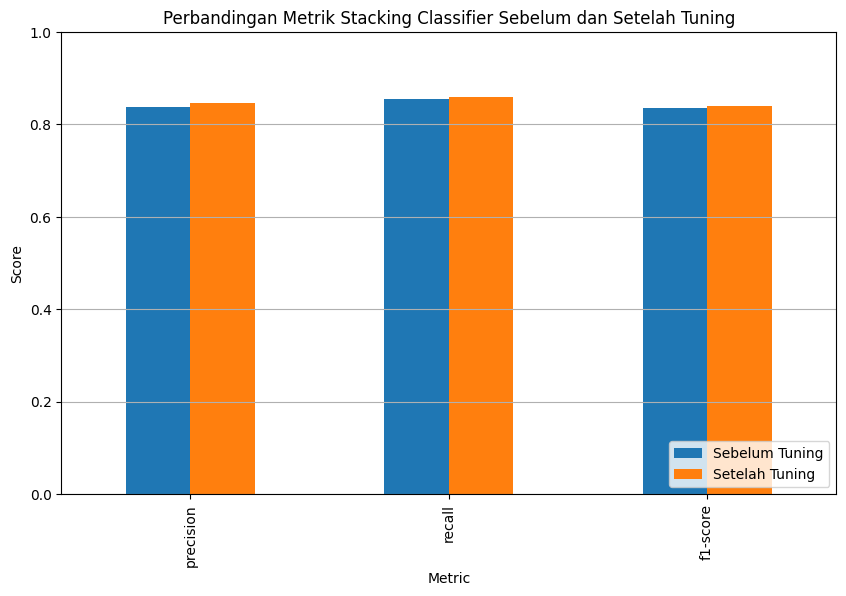

Fitting 2 folds for each of 6 candidates, totalling 12 fits
              precision    recall  f1-score   support

           0       0.72      0.36      0.48       153
           1       0.87      0.97      0.92       693

    accuracy                           0.86       846
   macro avg       0.80      0.66      0.70       846
weighted avg       0.85      0.86      0.84       846



In [391]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

# Stacking model (tanpa tuning)
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    n_jobs=-1
)

# Latih stacking tanpa tuning (sebagai baseline)
stacking.fit(X_train, y_train)
y_pred_before = stacking.predict(X_val)

print("=== Classification Report Sebelum Tuning ===")
print(classification_report(y_val, y_pred_before))

# Parameter tuning untuk final estimator XGBoost
param_dist = {
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__max_depth': [3, 5],
    'final_estimator__learning_rate': [0.05, 0.1],
}

search = RandomizedSearchCV(
    estimator=stacking,
    param_distributions=param_dist,
    n_iter=6,
    scoring='f1_weighted',
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Jalankan tuning
search.fit(X_train, y_train)

# Prediksi hasil tuning
y_pred_after = search.predict(X_val)

print("=== Classification Report Setelah Tuning ===")
print(classification_report(y_val, y_pred_after))

# Ambil report dalam bentuk dict untuk visualisasi
report_before = classification_report(y_val, y_pred_before, output_dict=True)
report_after = classification_report(y_val, y_pred_after, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Sebelum Tuning': [report_before['weighted avg'][m] for m in metrics],
    'Setelah Tuning': [report_after['weighted avg'][m] for m in metrics],
})

print("\n📊 Perbandingan Metrik:")
print(comparison_df)

# Plot perbandingan metrik
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10,6))
plt.title("Perbandingan Metrik Stacking Classifier Sebelum dan Setelah Tuning")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

search.fit(X_train, y_train)

# Evaluasi
from sklearn.metrics import classification_report
y_pred_stack = search.predict(X_val)
print(classification_report(y_val, y_pred_stack))


In [393]:
import joblib

# Simpan model
joblib.dump(best_model, 'model_hoax.pkl')

# Simpan vectorizer TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [394]:
import joblib

# Load model
loaded_model = joblib.load('model_hoax.pkl')

# Load TF-IDF vectorizer
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Tes prediksi dengan model yang dimuat ulang
def predict_hoax_loaded(text):
    cleaned = clean_text(text)
    X_input = loaded_vectorizer.transform([cleaned])
    prob = loaded_model.predict_proba(X_input)[0][1]
    print(f"Teks: {text}")
    print(f"Probabilitas Hoax: {prob*100:.2f}%")
    print(f"Kesimpulan: {'HOAX' if prob >= 0.5 else 'Bukan Hoax'}")


In [416]:
import pandas as pd

# Fungsi prediksi yang mengembalikan label HOAX atau Bukan Hoax saja
def predict_label(text):
    cleaned = clean_text(text)  # Pastikan fungsi clean_text sudah didefinisikan
    X_input = loaded_vectorizer.transform([cleaned])
    prob = loaded_model.predict_proba(X_input)[0][1]
    return 'HOAX' if prob >= 0.5 else 'Bukan Hoax'

# Pastikan test_data adalah DataFrame yang memuat kolom 'teks'
# Contoh test_data sudah ada, jika belum buat dulu seperti ini:
# test_data = pd.DataFrame({'teks': [...daftar teks...]})

# Prediksi untuk setiap baris
test_data['prediksi_hoax'] = test_data['teks'].apply(predict_label)

# Pisahkan data Hoax dan Bukan Hoax
hoax_data = test_data[test_data['prediksi_hoax'] == 'HOAX']
bukan_hoax_data = test_data[test_data['prediksi_hoax'] == 'Bukan Hoax']

# Simpan ke CSV
hoax_data.to_csv('hoax_data.csv', index=False)
bukan_hoax_data.to_csv('bukan_hoax_data.csv', index=False)

print(f"Data HOAX disimpan ke 'hoax_data.csv', jumlah baris: {len(hoax_data)}")
print(f"Data BUKAN HOAX disimpan ke 'bukan_hoax_data.csv', jumlah baris: {len(bukan_hoax_data)}")

Data HOAX disimpan ke 'hoax_data.csv', jumlah baris: 428
Data BUKAN HOAX disimpan ke 'bukan_hoax_data.csv', jumlah baris: 42


In [422]:
predict_hoax_loaded(" Bpk presiden RI tolong anak kakak saya, mengidap kanker tulang. Tak punya biaya untuk operasi")
predict_hoax_loaded("klarifikasi kpk terkait foto setya novanto")
predict_hoax_loaded("Klarifikasi Kepala BKPSDM Kabupaten Pamekasan Terkait Isu Penerimaan 80")

Teks:  Bpk presiden RI tolong anak kakak saya, mengidap kanker tulang. Tak punya biaya untuk operasi
Probabilitas Hoax: 96.00%
Kesimpulan: HOAX
Teks: klarifikasi kpk terkait foto setya novanto
Probabilitas Hoax: 28.00%
Kesimpulan: Bukan Hoax
Teks: Klarifikasi Kepala BKPSDM Kabupaten Pamekasan Terkait Isu Penerimaan 80
Probabilitas Hoax: 20.00%
Kesimpulan: Bukan Hoax
